# Fake news detection Explained


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [5]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [6]:
fake.shape

(23481, 4)

In [7]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [8]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [9]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
#data = shuffle(data)
print(data)
#data=data.iloc[:5]
data.shape
print(data)


#data = data.reset_index(drop=True)

                                                   title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
44893  'Fully committed' NATO backs new U.S. approach...   
44894  LexisNexis withdrew two products from Chinese ...   
44895  Minsk cultural hub becomes haven from authorities   
44896  Vatican upbeat on possibility of Pope Francis ...   
44897  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
0      Donald Trump just couldn t wish all Americans ...       News   
1      House Intelligence Committee Chairman Devin Nu...       News   
2      On Friday, it was revealed that former Milwauk...       New

In [10]:
# Shuffle the data

from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [11]:
# Check the data
print(type(data))
data.head()

<class 'pandas.core.frame.DataFrame'>


,title,text,subject,date,target
0,U.S. business group worries Trump unprepared f...,BEIJING (Reuters) - A top U.S. business lobby ...,politicsNews,"October 31, 2017",true
1,"Tillerson, Zarif spoke directly at Iran nuclea...",UNITED NATIONS (Reuters) - U.S. Secretary of S...,worldnews,"September 21, 2017",true
2,Republicans seek special counsel's removal fro...,WASHINGTON (Reuters) - Three Republican U.S. l...,politicsNews,"November 3, 2017",true
3,FARMER FINED A WHOPPING $2.8 MILLION Asks Pres...,A California farmer fined $2.8 million for plo...,Government News,"Jul 29, 2017",fake
4,CLIMATE CHANGE DENIERS BEWARE: The DOJ Wants T...,"In a shocking exchange on Wednesday, Attorney ...",Government News,"Mar 10, 2016",fake


In [12]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,U.S. business group worries Trump unprepared f...,BEIJING (Reuters) - A top U.S. business lobby ...,politicsNews,true
1,"Tillerson, Zarif spoke directly at Iran nuclea...",UNITED NATIONS (Reuters) - U.S. Secretary of S...,worldnews,true
2,Republicans seek special counsel's removal fro...,WASHINGTON (Reuters) - Three Republican U.S. l...,politicsNews,true
3,FARMER FINED A WHOPPING $2.8 MILLION Asks Pres...,A California farmer fined $2.8 million for plo...,Government News,fake
4,CLIMATE CHANGE DENIERS BEWARE: The DOJ Wants T...,"In a shocking exchange on Wednesday, Attorney ...",Government News,fake


In [13]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,BEIJING (Reuters) - A top U.S. business lobby ...,politicsNews,true
1,UNITED NATIONS (Reuters) - U.S. Secretary of S...,worldnews,true
2,WASHINGTON (Reuters) - Three Republican U.S. l...,politicsNews,true
3,A California farmer fined $2.8 million for plo...,Government News,fake
4,"In a shocking exchange on Wednesday, Attorney ...",Government News,fake


In [14]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,beijing (reuters) - a top u.s. business lobby ...,politicsNews,true
1,united nations (reuters) - u.s. secretary of s...,worldnews,true
2,washington (reuters) - three republican u.s. l...,politicsNews,true
3,a california farmer fined $2.8 million for plo...,Government News,fake
4,"in a shocking exchange on wednesday, attorney ...",Government News,fake


In [15]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [16]:
# Check
data.head()

,text,subject,target
0,beijing reuters a top us business lobby in ch...,politicsNews,true
1,united nations reuters us secretary of state ...,worldnews,true
2,washington reuters three republican us lawmak...,politicsNews,true
3,a california farmer fined 28 million for plowi...,Government News,fake
4,in a shocking exchange on wednesday attorney g...,Government News,fake


In [17]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /Users/evan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
data.head()

,text,subject,target
0,beijing reuters top us business lobby china sa...,politicsNews,true
1,united nations reuters us secretary state rex ...,worldnews,true
2,washington reuters three republican us lawmake...,politicsNews,true
3,california farmer fined 28 million plowing ver...,Government News,fake
4,shocking exchange wednesday attorney general l...,Government News,fake


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


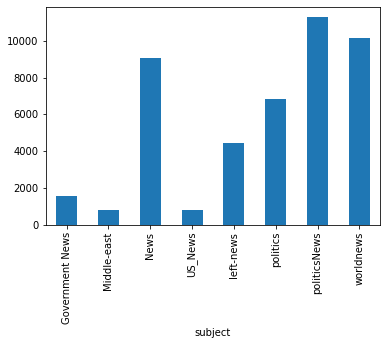

In [19]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


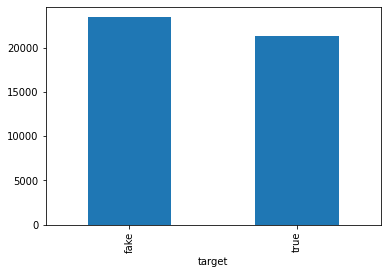

In [20]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

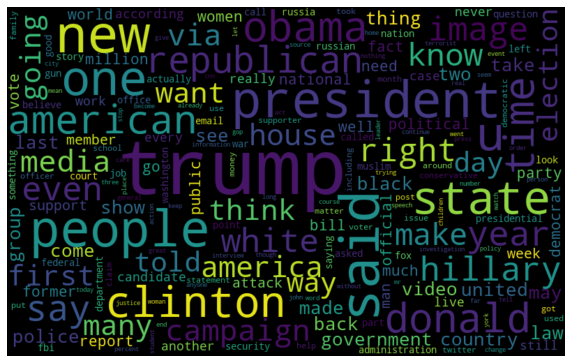

In [21]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

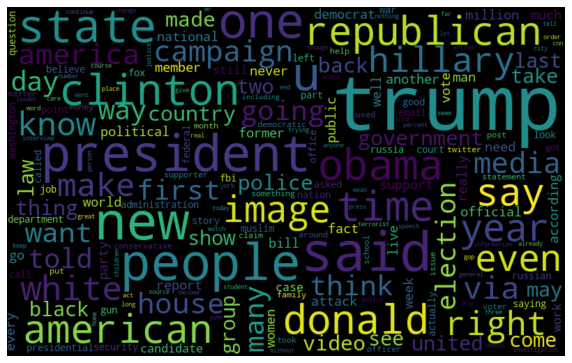

In [22]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

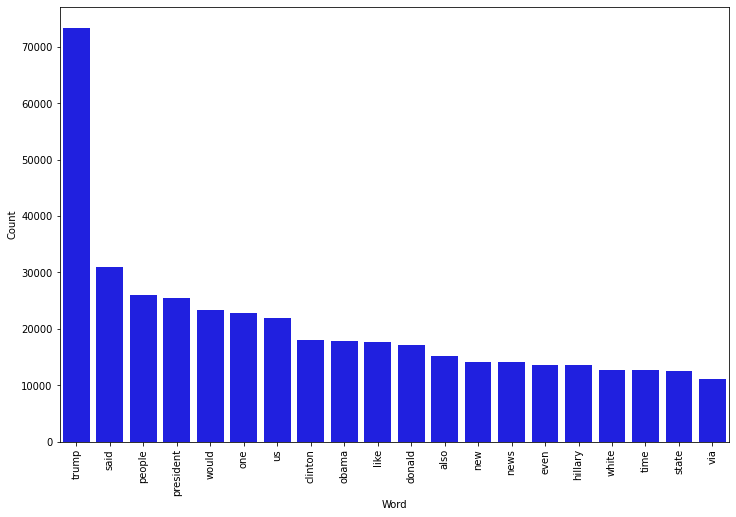

In [24]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

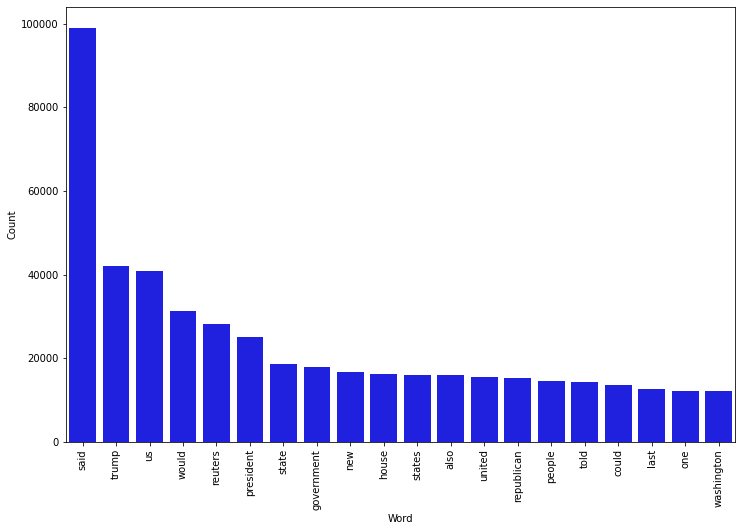

In [25]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [26]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [27]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)
#print(type(data))
print(type(X_test))
X_test=np.array(X_test)
print(type(X_test))
#print(y_test)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


# **Naive Bayes**




In [28]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.12%


Confusion matrix, without normalization


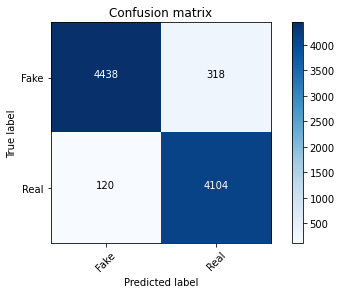

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [30]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

'''
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

'''
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, shuffle=False)
print('xtrain shape = ',X_train.shape)
print('ytrain shape = ',y_train.shape)
print('x_test shape = ',X_test.shape)
print('y_test shape = ',y_test.shape)

X_total=pd.concat([X_train,X_test])
print('X_total shape = ',X_total.shape)
ltotal=len(X_total)
#print(X_total)
'''
vectorizer = CountVectorizer()
v = vectorizer.fit_transform(X_total)
features=vectorizer.get_feature_names_out()
tfr=TfidfTransformer()
tf=tfr.fit_transform(v)
'''
vectorizer=TfidfVectorizer(lowercase=False)
v = vectorizer.fit_transform(X_total)
features=vectorizer.get_feature_names_out()
tf=v


print('tf total shape = ',tf.shape)
print('len(tf) = ', tf.shape[0])
ltrain=X_train.shape[0]
print('ltrain = ',ltrain)
tftrain=tf[0:ltrain][:]
tftest=tf[ltrain:][:]

print('tftrain shape = ', tftrain.shape)
print('tftest shape = ',tftest.shape)



mo=LogisticRegression()
mo.fit(tftrain,y_train)
m=mo.predict(tftest)
print(m)
prediction = mo.predict(tftest)
print('prediction shape = ',prediction.shape)

print('prediction : ',prediction)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)




xtrain shape =  (35918,)
ytrain shape =  (35918,)
x_test shape =  (8980,)
y_test shape =  (8980,)
X_total shape =  (44898,)
tf total shape =  (44898, 225972)
len(tf) =  44898
ltrain =  35918
tftrain shape =  (35918, 225972)
tftest shape =  (8980, 225972)
['fake' 'fake' 'true' ... 'fake' 'fake' 'true']
prediction shape =  (8980,)
prediction :  ['fake' 'fake' 'true' ... 'fake' 'fake' 'true']
accuracy: 98.83%


In [54]:
from lime import lime_tabular
#print(X_test)
l=len(X_test)
print(l)
i = np.random.randint(1, l)
j=i+ltrain
p=mo.predict(tftest)

print(type(X_test[j]))

#print('xtrain type = ',type(X_train[12]))
#print(X_test[j])
#print(np.array(X_test[i]).shape)

#h="hello world"
#raw_h = r'{}'.format(h)
#print(type(raw_h))

#vectorizer.transform(raw_h)

def predict_fn(news): #Prediction fonction : takes 
    #news=r'news'
    vk=vectorizer.transform(news)
    r=mo.predict(vk)
    return(r)

print(predict_fn(X_train[j]))

pi=p[i]
#print('p = ',p)
#print('i = ',i)
#print('y_test = ',y_test)
#print("Prediction : ", pi)

#print("Actual : ", y_test[j])

explainer = lime_tabular.LimeTabularExplainer(tf, mode="regression", feature_names= features)
explainer
#print(X_test)
#print(np.array(X_test[j]))
#print(X_test)
#print('number features = ',)
tfs=tf.shape[1]
#print(tftest[i])


explanation = explainer.explain_instance(X_test[j], predict_fn, num_features=tfs)

explanation
explanation.show_in_notebook()


8980
<class 'str'>
<class 'str'>


ValueError: Iterable over raw text documents expected, string object received.

Confusion matrix, without normalization


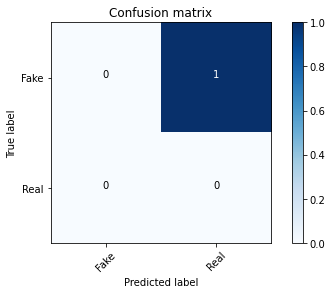

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 0.0%


Confusion matrix, without normalization


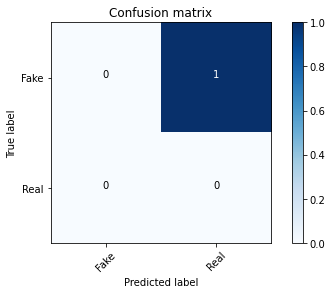

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 0.0%


Confusion matrix, without normalization


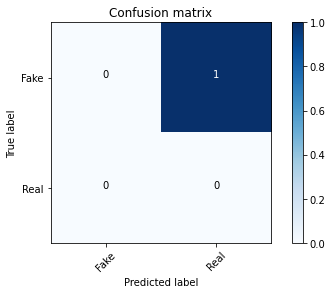

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)



Confusion matrix, without normalization


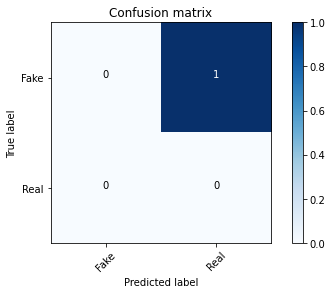

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x7f7e96b0e670>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

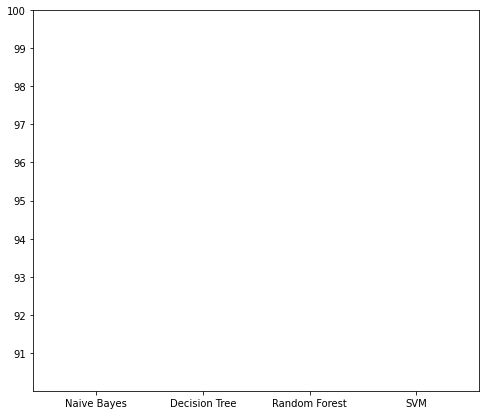

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

In [ ]:
the end.....

SyntaxError: invalid syntax (2237372829.py, line 1)